#Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning.
##José María Ibarra A01706970

#Introducción

El diagnóstico de enfermedades ha sido tradicionalmente abordado por disciplinas médicas. Sin embargo, los avances recientes en tecnología, especialmente en inteligencia artificial, han permitido aprovechar estas herramientas y ofrecer nuevas perspectivas para abordar estas situaciones. En particular, las redes neuronales convolucionales han demostrado ser eficaces para identificar y clasificar imágenes, convirtiéndose en valiosos asistentes en el diagnóstico de diversas afecciones.

En este contexto, se entrena una red neuronal destinada a clasificar melanomas, un tipo de cáncer de piel. La base de datos utilizada se encuentra en: https://www.kaggle.com/datasets/drscarlat/melanoma

Para llevar a cabo este proceso, es necesario realizar la carga inicial de datos mediante el uso de la API de Kaggle:

#Datos

In [2]:
#instalar api de kaggle

!pip install -q kaggle

In [3]:
#conectar a kaggle

from google.colab import files

files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#descargar base de datos

!kaggle datasets download -d drscarlat/melanoma

100% 5.25G/5.26G [01:01<00:00, 135MB/s]
100% 5.26G/5.26G [01:01<00:00, 91.2MB/s]


In [ ]:
#descompresión de archivos en el entorno de trabajo

!unzip /content/melanoma.zip

Una vez que tenemos acceso al archivo .zip con las imágenes, importamos las dependenicas necesarias para usarlas en con *tensorflow.keras* y cargamos las imágenes en tres instanicas, una de entrenamiento, una de validación y otra de prueba.

In [18]:
#librerías

import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf

#directorios

train_directory = '/content/DermMel/train_sep'
test_directory = '/content/DermMel/test'
valid_directory = '/content/DermMel/valid'

image_size = (256, 256) #tamaño de las imágenes
batch_size = 64 #establecer tamaño de batches para entrenamiento y validación

#entrenamiento
melanoma_train = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    shuffle=True,
    seed=10,
    color_mode='rgb',
    batch_size=batch_size
)

#prueba
melanoma_test = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    shuffle=False,
    seed=10,
    color_mode='rgb',
)

#validación
melanoma_val = tf.keras.utils.image_dataset_from_directory(
    valid_directory,
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    shuffle=True,
    seed=10,
    color_mode='rgb',
    batch_size=batch_size
)

#contar imágenes
class_names = melanoma_train.class_names
image_counts_train = {class_name: 0 for class_name in class_names}
image_counts_test = {class_name: 0 for class_name in class_names}
image_counts_val = {class_name: 0 for class_name in class_names}

for _, labels in melanoma_train:
    for label in labels:
        class_name = class_names[label]
        image_counts_train[class_name] += 1

for _, labels in melanoma_test:
    for label in labels:
        class_name = class_names[label]
        image_counts_test[class_name] += 1

for _, labels in melanoma_val:
    for label in labels:
        class_name = class_names[label]
        image_counts_val[class_name] += 1

#desplegar info
for class_name, count in image_counts_train.items():
    print(f"Entrenamiento - Clase: {class_name}, Imágenes: {count}")

for class_name, count in image_counts_test.items():
    print(f"Prueba - Clase: {class_name}, Imágenes: {count}")

for class_name, count in image_counts_val.items():
    print(f"Validación - Clase: {class_name}, Imágenes: {count}")

Found 10682 files belonging to 2 classes.
Found 3561 files belonging to 2 classes.
Found 3562 files belonging to 2 classes.
Entrenamiento - Clase: Melanoma, Imágenes: 5341
Entrenamiento - Clase: NotMelanoma, Imágenes: 5341
Prueba - Clase: Melanoma, Imágenes: 1781
Prueba - Clase: NotMelanoma, Imágenes: 1780
Validación - Clase: Melanoma, Imágenes: 1781
Validación - Clase: NotMelanoma, Imágenes: 1781


In [ ]:
# visualizar batch

for image, label in melanoma_train.take(1): #visualizamos un batch para confirmar variedad de los datos
  print(label)

tf.Tensor(
[1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 0
 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0], shape=(64,), dtype=int32)


Podemos visualizar algunas imágenes

Entrenamiento:


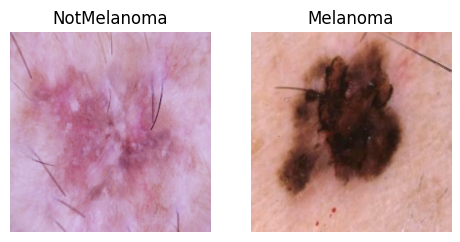

Prueba:


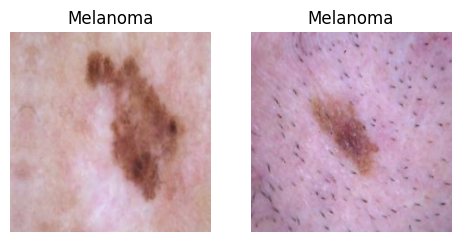

Validación:


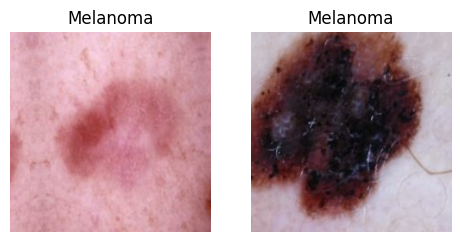

In [ ]:
#visualización de imágenes

import matplotlib.pyplot as plt

def display_images(dataset, class_names):
    plt.figure(figsize=(15, 10))

    for images, labels in dataset.take(1):
        for i in range(len(class_names)):
            class_index = labels[i].numpy()
            class_name = class_names[class_index]
            image = images[i].numpy().astype("uint8")

            plt.subplot(3, 5, i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")

    plt.show()

print("Entrenamiento:")
display_images(melanoma_train, class_names)

print("Prueba:")
display_images(melanoma_test, class_names)

print("Validación:")
display_images(melanoma_val, class_names)


#Desarrollo del modelo

Una vez cargadas las imágenes con la configuración correcta para implementarlas en el entrenamiento de un modelo, es necesario compliar una arquitectura.

La primera arquitectura propuesta consiste de una red neuronal profunda relativamente sencilla. Consiste en:


1.   Capa de convolución 2D con 64 filtros y activación *ReLu*. Además se le asigna la forma de la entrada al ser la capa de entrada de la red.
2.   MaxPooling 2x2
3.   Convolución de 128 canales y activación *ReLu*
4.   MaxPooling 2D
5.   Capa de Flatten (1D)
6.   Capa de salida con activación *sigmoid*, para clasificación binaria

Además, se utiliza la función de pérdida *binary_crossentropy* y el optimizador *Adam* con un *learning rate* de 0.005.



In [ ]:
#reiniciar sesión de keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

##Modelo 1

In [ ]:
#modelo 1

from keras import layers, regularizers

model_v1 = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

#optimizador
lr = 0.005
opt = keras.optimizers.Adam(learning_rate=lr)

#compilar
model_v1.compile(loss='binary_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

Podemos ver una descripción de la arquitectura propuesta con sus parámetros por capa.

In [ ]:
#arquitectura

model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 1)                 4

Entrenamos el modelo con *EarlyStopping* para eficientar el proceso. Si luego de tres épocas de entrenamiento no hay un cambio considerable en la función de pérdida de validación, se para el entrenamiento.

In [ ]:
#entrenamiento

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.1,
    patience=3,
    restore_best_weights=True
)

history_v1 = model_v1.fit(
    melanoma_train,
    batch_size=64,
    epochs=20,
    validation_data=melanoma_val,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
167/167 [==============================] - 69s 400ms/step - loss: 223.5969 - accuracy: 0.5103 - val_loss: 0.6882 - val_accuracy: 0.5112
Epoch 2/20
167/167 [==============================] - 64s 374ms/step - loss: 0.6895 - accuracy: 0.5068 - val_loss: 0.6868 - val_accuracy: 0.5135
Epoch 3/20
167/167 [==============================] - 59s 344ms/step - loss: 1.9954 - accuracy: 0.5080 - val_loss: 0.6885 - val_accuracy: 0.5124
Epoch 4/20
167/167 [==============================] - 67s 393ms/step - loss: 0.6867 - accuracy: 0.5073 - val_loss: 0.6874 - val_accuracy: 0.5126


Podemos ver que este modelo no parece tener la complejidad suficiente para extraer las características visuales de las imágenes. Las métricas de entrenamiento nos hablas de un caso de *under-fitting*.

Sabemos por la visualización de las imágenes que estas parecen ser un poco complejas tanto en formas como en canales (RGB), por tanto, es probable que sea productivo proponer una arquitectura más compleja.


#Ajuste del modelo

##Modelo 2

La arquitectura más compleja propuesta es:

1. Capa de Convolución 2D (Conv2D):
64 filtros de tamaño (3, 3) con activación ReLU.
Esta capa también sirve como la capa de entrada de la red y tiene una forma de entrada de (256, 256, 3).

2. Capa de Convolución 2D (Conv2D):
64 filtros de tamaño (3, 3) con activación ReLU.
Capa secuencial después de la primera capa de convolución.
Capa de MaxPooling 2D:

3. Operación de MaxPooling con una ventana de (2, 2).
Reduce las dimensiones espaciales de la salida de la capa anterior.

4. Capa de Convolución 2D (Conv2D):
128 filtros de tamaño (3, 3) con activación ReLU.

5. Capa de Convolución 2D (Conv2D):
128 filtros de tamaño (3, 3) con activación ReLU.
Capa secuencial después de la segunda capa de convolución.

6. Capa de MaxPooling 2D:
Operación de MaxPooling con una ventana de (2, 2).
Reduce las dimensiones espaciales de la salida de la capa anterior.

7. Capa Densa (Fully Connected):
1024 neuronas con activación ReLU.


8. Capa de Flatten:
Convierte la salida de la capa anterior a una dimensión unidimensional.

9. Capa de Salida:
Capa densa con 1 neurona y activación sigmoid, adecuada para clasificación binaria.

Se aplica regularización L1 y L2 (*Elastic net regularization*), y se incluye una capa de Dropout con una tasa del 30% para prevenir el *overfitting*.

La compilación del modelo utiliza la función de pérdida *binary_crossentropy*, optimizador *Adam* con un *learning rate* de 0.001.

In [ ]:
#modelo 2

from keras import layers, regularizers

l1_strength = 0.05
l2_strength = 0.005

model_v2 = keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dense(1024, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=l1_strength, l2=l2_strength)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

#optimizador
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)

#compilar
model_v2.compile(loss='binary_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])

Para este modelo duplicamos las capas de convolución. Además, agregamos Una capa de *Dropout* para evitar *overfitting*, así como *Elastic net regularization*. También modificamos el *learning rate* a 0.001, el cual tiende a ser más eficiente con *Adam*.

In [ ]:
#arquitectura

model_v2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 61, 61, 128)       0         
 g2D)                                                 

Mantenemos los estándares de entrenamiento.

In [ ]:
#entrenamiento

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.1,
    patience=3,
    restore_best_weights=True
)

history_v2 = model_v2.fit(
    melanoma_train,
    batch_size=64,
    epochs=20,
    validation_data=melanoma_val,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
167/167 [==============================] - 194s 1s/step - loss: 141.0583 - accuracy: 0.6303 - val_loss: 72.0354 - val_accuracy: 0.6269
Epoch 2/20
167/167 [==============================] - 168s 1000ms/step - loss: 58.9321 - accuracy: 0.7022 - val_loss: 48.0348 - val_accuracy: 0.6159
Epoch 3/20
167/167 [==============================] - 171s 1s/step - loss: 40.1162 - accuracy: 0.6537 - val_loss: 33.0780 - val_accuracy: 0.6595
Epoch 4/20
167/167 [==============================] - 167s 991ms/step - loss: 27.6667 - accuracy: 0.6801 - val_loss: 22.7978 - val_accuracy: 0.7125
Epoch 5/20
167/167 [==============================] - 166s 986ms/step - loss: 19.0016 - accuracy: 0.6681 - val_loss: 15.6212 - val_accuracy: 0.7010
Epoch 6/20
167/167 [==============================] - 167s 990ms/step - loss: 13.0914 - accuracy: 0.6743 - val_loss: 10.5387 - val_accuracy: 0.7072
Epoch 7/20
167/167 [==============================] - 167s 992ms/step - loss: 8.7046 - accuracy: 0.7022 - val_loss: 

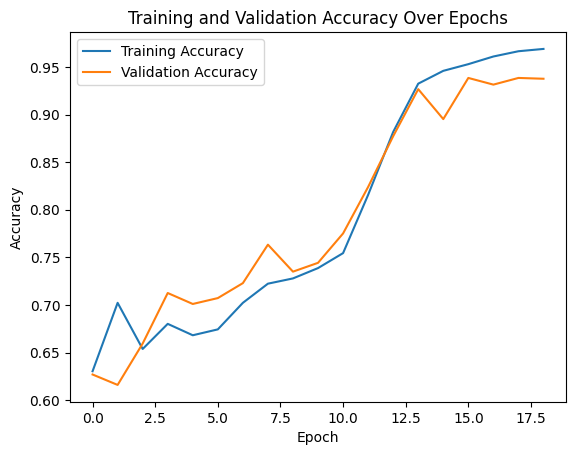

In [ ]:
#gráficos de entrenamiento

plt.plot(history_v2.history['accuracy'], label='Training Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Podemos ver que al añadir complejidad al modelo y nuevas capas, el entrenamiento tiene un mucho mejor rendimiento. Además, parece haber indicio que el entrenamiento se paró justo antes de caer en *overfitting*, como puede entenderse por la separación que presentan las curvas de entrenamiento y validación hacia las últimas épocas. Realizamos una evaluación con el set de pruebas para verificar el rendimiento de este modelo con imágenes que no ha visto.

In [ ]:
#guardar modelo

model_v2.save("melanoma_detection_model_v2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Resultados

In [ ]:
#test

evaluation = model_v2.evaluate(melanoma_test)
loss = evaluation[0]
accuracy = evaluation[1]

print(f"Loss: {loss}, Accuracy: {accuracy}")

112/112 [==============================] - 18s 159ms/step - loss: 0.8576 - accuracy: 0.9278
Loss: 0.8576030135154724, Accuracy: 0.9278292655944824


Podemos observar que, como indicaban las métricas de validación, el modelo tiene un gran rendimiento con imágenes nuevas.

Obtenemos un reporte completo, con matriz de confusión y curva ROC.

112/112 [==============================] - 16s 145ms/step
		Matriz de confusión:

[[1549  232]
 [  25 1755]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1781
           1       0.88      0.99      0.93      1780

    accuracy                           0.93      3561
   macro avg       0.93      0.93      0.93      3561
weighted avg       0.93      0.93      0.93      3561

AUC (área bajo la curva): 0.957120731314941


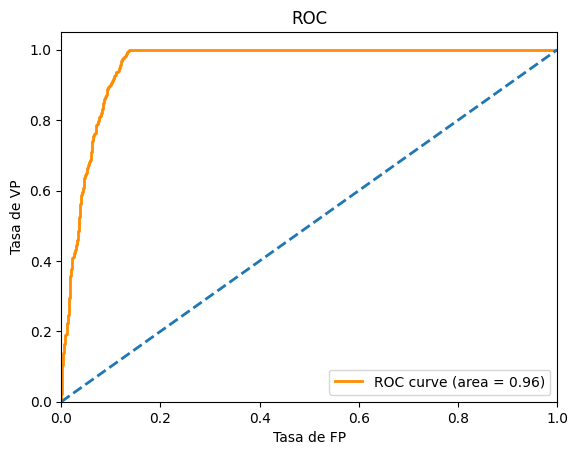

In [ ]:
#reporte de métricas

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_pred_probs = model_v2.predict(melanoma_test)
y_pred_binary = (y_pred_probs > 0.5).astype(int).flatten()
y_true = np.concatenate([y for x, y in melanoma_test], axis=0)

confusion = confusion_matrix(y_true, y_pred_binary)
classification_rep = classification_report(y_true, y_pred_binary)

print("\t\tMatriz de confusión:\n")
print(confusion)

print("Classification Report:")
print(classification_rep)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC (área bajo la curva): {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de FP')
plt.ylabel('Tasa de VP')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()


Podemos observar algunas de las predicciones:

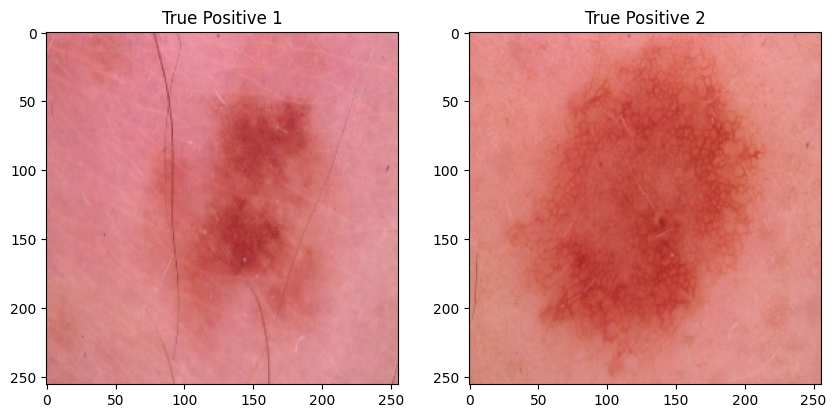

In [ ]:
#Predicciones positivas correctas

true_positive_indices = np.where((y_true == 1) & (y_pred_binary == 1))[0][:2]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, index in enumerate(true_positive_indices):
    image, _ = melanoma_test.unbatch().skip(index).take(1).as_numpy_iterator().next()
    axes[i].imshow(image.astype('uint8'))
    axes[i].set_title(f'True Positive {i + 1}')

plt.show()

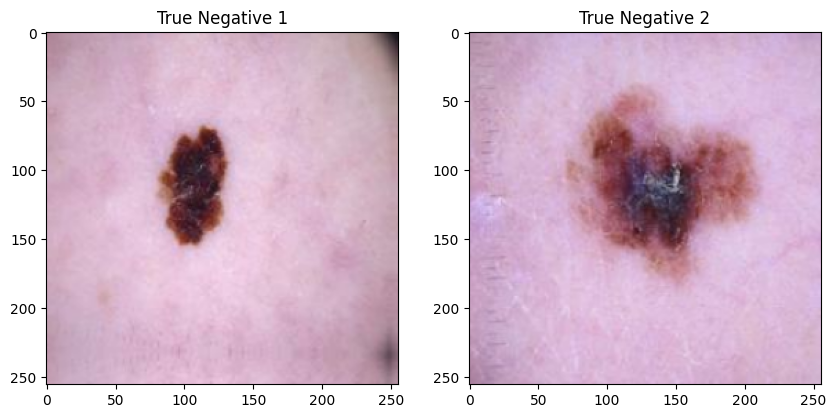

In [ ]:
#predicciones negativas correctas

true_negative_indices = np.where((y_true == 0) & (y_pred_binary == 0))[0][:2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, index in enumerate(true_negative_indices):
    image, _ = melanoma_test.unbatch().skip(index).take(1).as_numpy_iterator().next()
    axes[i].imshow(image.astype('uint8'))
    axes[i].set_title(f'True Negative {i + 1}')

plt.show()

#Conclusiones


El modelo obtenido parece tener un rendimiento general muy destacado. La curva ROC indica una eficiencia notable al diferenciar entre las dos clases.

En el contexto médico, es especialmente crucial poner un énfasis especial en la métrica de Recall, que mide la tasa de aciertos en los casos positivos verdaderos. Este enfoque es esencial para identificar todos los posibles casos de melanoma y evitar pasar por alto alguno. En este sentido, nuestro modelo muestra un rendimiento excelente, con un Recall para casos positivos de 0.99. Idealmente, esta métrica debería ir acompañada de un nivel alto de precisión, que mide la proporción de verdaderos positivos frente a todas las predicciones positivas. El modelo muestra un desempeño ligeramente inferior en esta medida, con un valor de 0.88. Por lo tanto, un trabajo futuro podría centrarse en evitar el overfitting e incrementar esta métrica.

Finalmente, observamos algunas imágenes que fueron clasificadas correctamente por el modelo, pertenecientes a ambas clases. Visualmente, parece haber una diferencia evidente para el ser humano, y es alentador que la arquitectura propuesta haya sido capaz de identificar las características fundamentales entre las dos clases.

#Predicciones individuales

[0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
[0.99973446]
1/1 [==============================] - 1s 1s/step


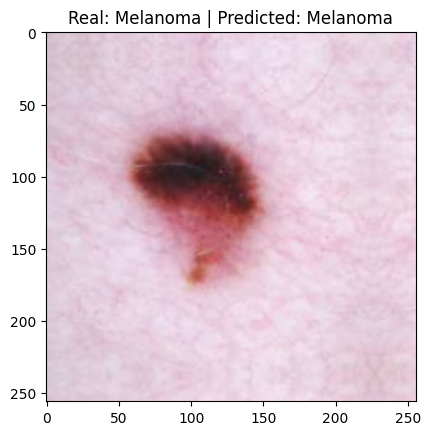

In [85]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt



model = load_model('/content/melanoma_detection_model_v2.h5')

batch_index = 1
image_index = 3 #cambiamos estos valores para seleccionar imágenes diferentes

for i, (image, label) in enumerate(melanoma_val):
    if i == batch_index:
        batch_labels = list(label.numpy())
        batch_imgs = image
        break
print(batch_labels)
print(pred.flatten())

labels_dict = {0:melanoma_test.class_names[0], 1:melanoma_test.class_names[1]}
img = image[image_index].numpy()

pred = model.predict(np.expand_dims(img, axis=0))

plt.imshow(img.astype("uint8"))
plt.title(f'Real: {labels_dict[batch_labels[image_index]]} | Predicted: {labels_dict[(pred[0][0]>0.5).astype(int)]}')
plt.show()